# Spectrum fitting for SN2014C from Chandra data.

ObsId: 17549 and 21077

In [4]:
# Standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
try:
    import xspec 
except: # If ModuleNotFoundError, initialize HEASOFT.
    print(f"PyXspec was not found, please initialize HEASOFT first in shell")
import xsnap
from xsnap import *

In [5]:
spec_files = ['./data/17569/primary/spec17569_grp.pi', 
              './data/21077/primary/spec21077_grp.pi']

# Using parameters from this paper:
# https://iopscience.iop.org/article/10.3847/1538-4357/ad9c76

# Time of explosion in MJD
tExplosion= 56658.91 # MJD

# Distance in Mpc
dist = 15.1 # Mpc

In [6]:
# Use constrain temperature with T = 34 keV (t/13)^(-0.25)
# Meaning it's 34 * (1/13)^(-0.25) t^(-0.25)
norm = 34 * (1/13)**(-0.25)
exp = -0.25

temp = TemperatureEstimator(norm=norm, exponent=exp, tExplosion=tExplosion)
df_temp = temp.estimate(files=spec_files)
df_temp # here we estimate the temperature based on our model

,time_since_explosion,lo_time_err,hi_time_err,temperature,lo_temp_err,hi_temp_err
0,393.706775,0.0,0.0,14.493442,0.0,0.0
1,1565.644759,0.0,0.0,10.263405,0.0,0.0


 Solar Abundance Vector set to aspl:  Asplund M., Grevesse N., Sauval A.J. & Scott P., ARAA, 47, 481 (2009)

1 spectrum  in use
 
Spectral Data File: /Users/ferdinand/Research/WynnXraySN/XSNAP/notebook/data/17569/primary/spec17569_grp.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.536e-02 +/- 1.601e-03 (99.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-192
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 9914 sec
 Using fit statistic: chi
 Using Background File                spec17569_bkg.pi
  Background Exposure Time: 9914 sec
 Using Response (RMF) File            spec17569.rmf for Source 1
 Using Auxiliary Response (ARF) File  spec17569.corr.arf


ignore:     1 channels ignored from  source number 1
     2 channels (1-2) ignored in spectrum #     1
     5 channels (188-192) ignored in spectrum #     1


Model TBabs<1>*zTBabs<2>*bremss<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  com

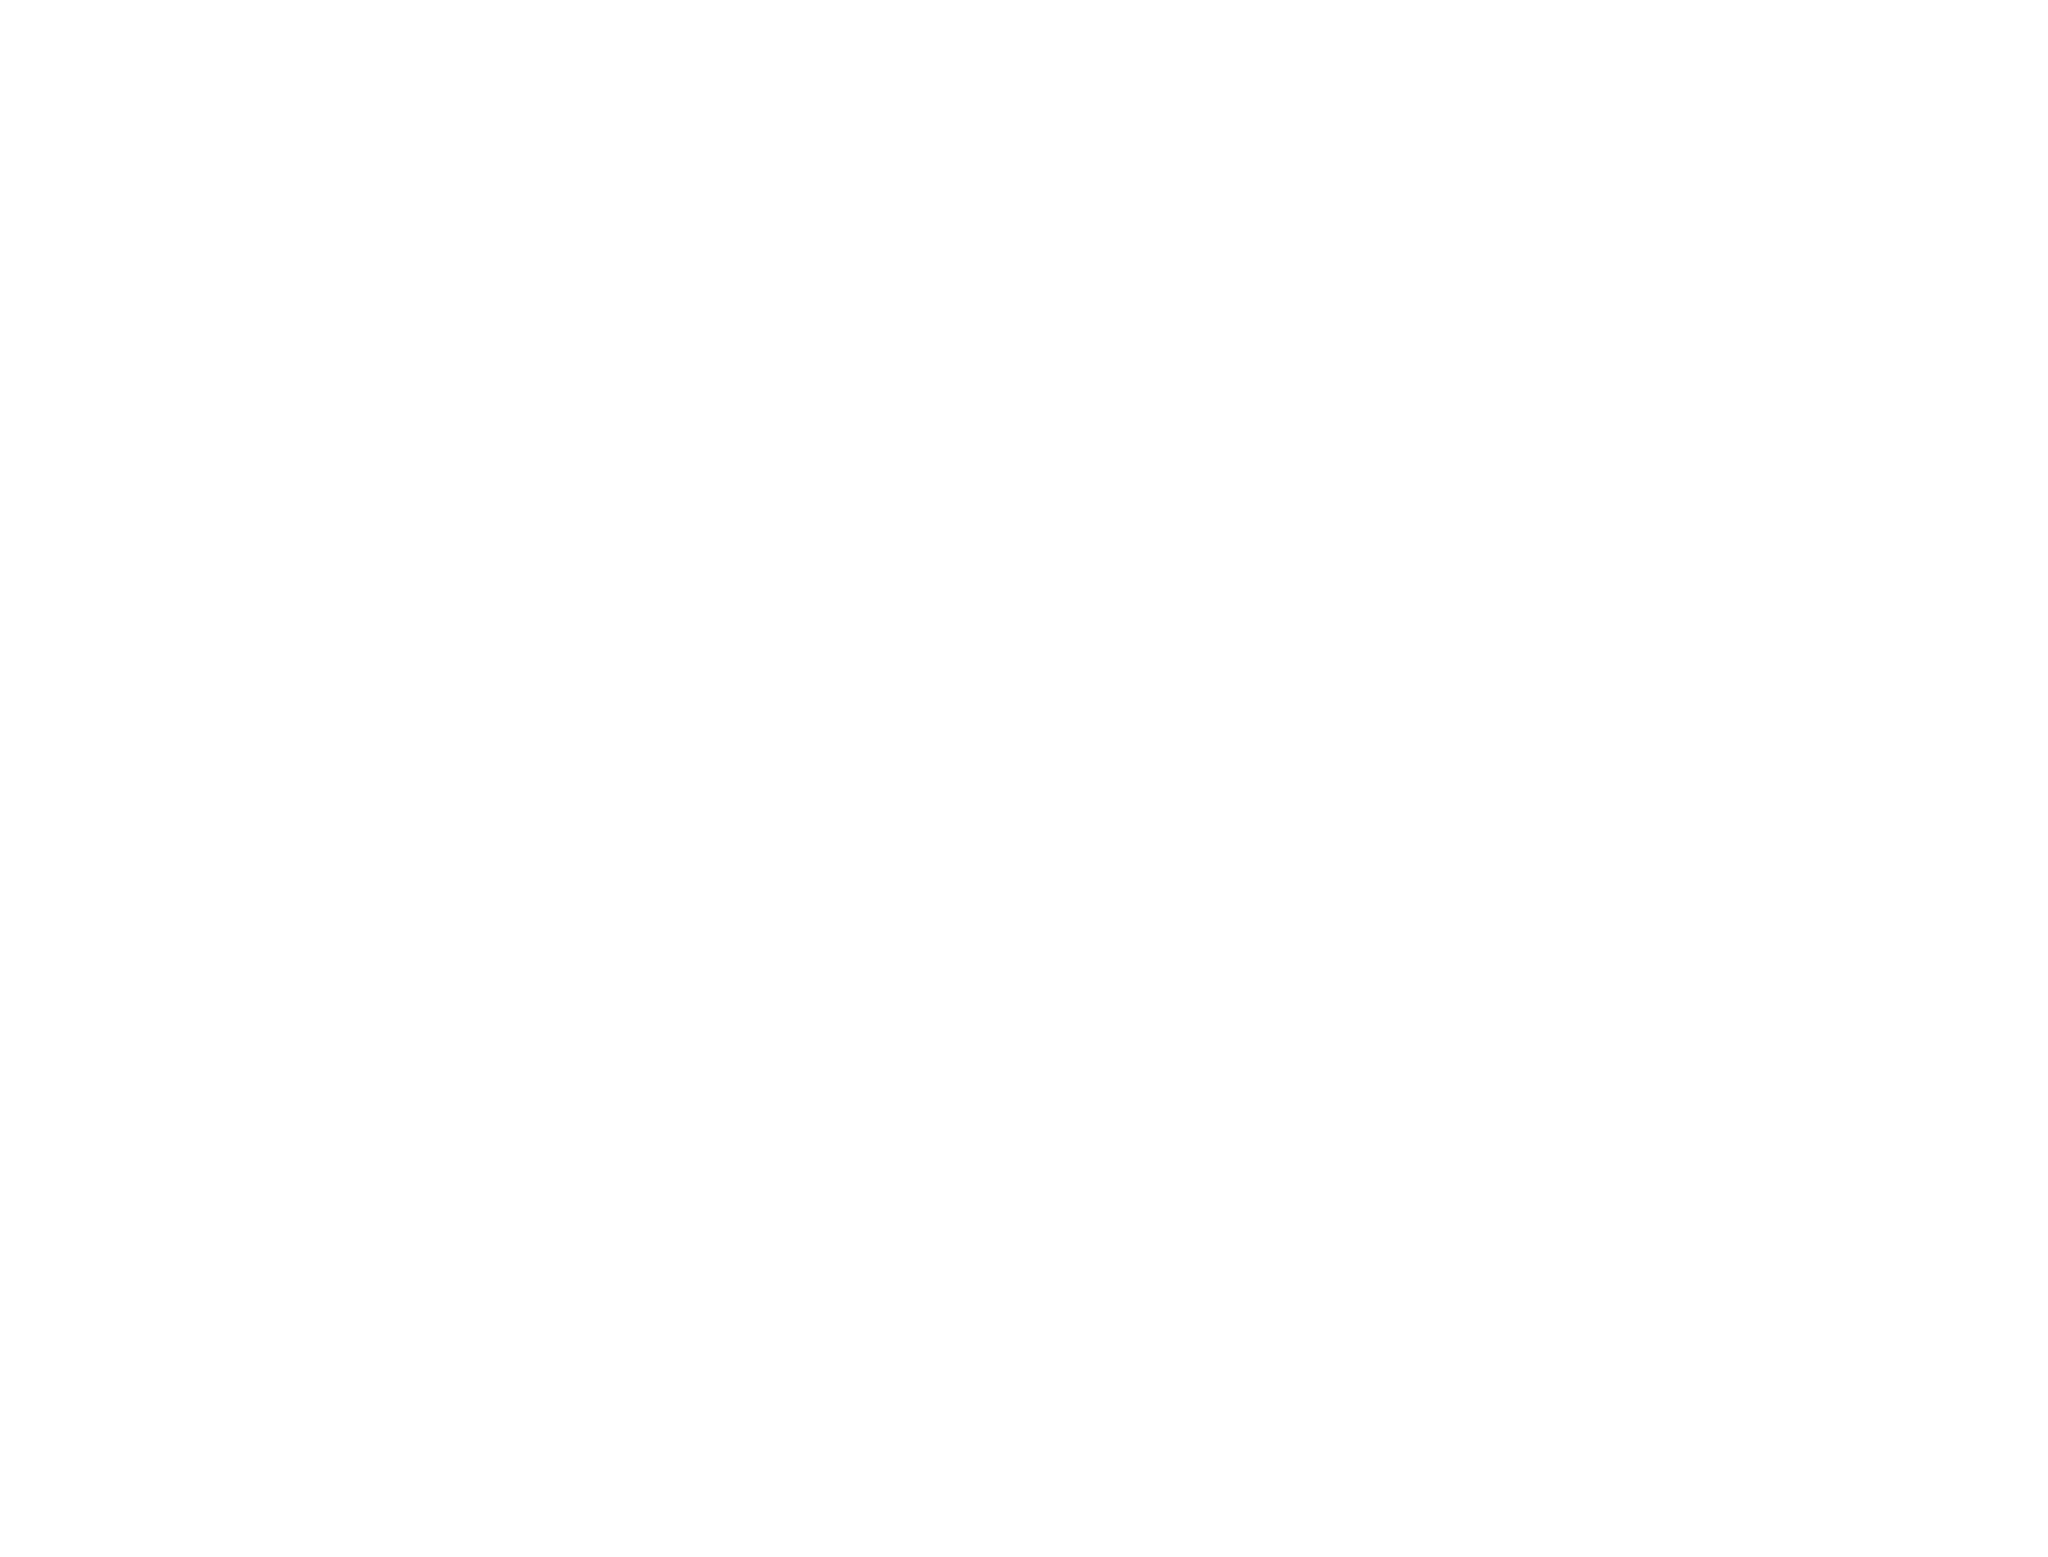

 Parameter   Confidence Range (1)
     2      2.30414      2.92709    (-0.29848,0.32447)
     5  0.000158819   0.00018985    (-1.48813e-05,1.61498e-05)
Spectrum 1: Lower range bound          0.3 reset by matrix bound to          0.3
Parameter distribution is derived from fit covariance matrix.
 Model Flux 8.638e-05 photons (5.9419e-13 ergs/cm^2/s) range (0.30000 - 10.000 keV)
     Error range 8.022e-05 - 9.217e-05    (5.500e-13 - 6.356e-13)  (68.00% confidence)

Fit statistic  : C-Statistic                  215.96     using 185 bins.

Test statistic : Chi-Squared                  244.75     using 185 bins.
 Null hypothesis probability of 1.56e-03 with 183 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                  609.99     using 185 bins.

Test statistic : Chi-Squared                 3405.62     using 185 bins.
 Null hypothesis probability of 0.00e+00 with 183 degrees of freedom
 Current data and model not fit yet.
         valid fit or chai

In [7]:
# Initialize SpectrumManager class to help in plotting light curve
manager = SpectrumManager(tExplosion = tExplosion)

# Fit the first spectrum
# SpectrumFit by default use 'aspl' for Solar Abundance
spec17569 = SpectrumFit() 
spec17569.load_data(spec_files[0])
spec17569.set_rebin(5, 3)
spec17569.ignore("**-0.5 8.0-**") # Chandra is well-calibrated in 0.5 - 8.0 keV

# Now, we set the model that we want
# Supposedly we use TBabs, TBabs can be automatically 
# calculated through the RA and Dec Obj available in 
# the header of the spectrum file
spec17569.set_model(
    "tbabs*ztbabs*bremss",
    zTBabs_nH=2.7,
    zTBabs_Redshift=0,
    # Here, we freeze the temperature for tutorial purposes
    bremss_kT=f"{df_temp['temperature'].iloc[0]} -1",
    bremss_norm=0
)

spec17569.fit()
# We set plot, if device="/null" it automatically uses matplotlib to plot
spec17569.set_plot("ldata", device="/svg")
# Fitting the parameters for zTBabs nH and bremss norm
spec17569.get_params("1.0 2 5")
# Get both absorbed and unabsorbed fluxes
df_flux = spec17569.get_fluxes()
# Getting observation time to help in plotting the light curve
spec17569.get_time()
# Getting count rates
spec17569.get_counts()
# Getting luminosity based on given flux and distance
spec17569.get_lumin(fluxes=df_flux['unabsorbed'], distance=dist) 

# Load the spectrum to the manager
# Due to the nature of PyXspec,
# You must fit the spectrum and 
# load it to the manager one by one
manager.load(spec17569)

 Solar Abundance Vector set to aspl:  Asplund M., Grevesse N., Sauval A.J. & Scott P., ARAA, 47, 481 (2009)

Fit statistic  : C-Statistic                  609.99     using 185 bins.

Test statistic : Chi-Squared                 3405.62     using 185 bins.
 Null hypothesis probability of 0.00e+00 with 183 degrees of freedom
 Current data and model not fit yet.

1 spectrum  in use
 
Spectral Data File: /Users/ferdinand/Research/WynnXraySN/XSNAP/notebook/data/21077/primary/spec21077_grp.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.856e-02 +/- 1.568e-03 (99.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-345
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 1.979e+04 sec
 Using fit statistic: cstat
 Using Background File                spec21077_bkg.pi
  Background Exposure Time: 1.979e+04 sec
 Using Response (RMF) File            spec21077.rmf for Source 1
 Using Auxiliary Response (ARF) File  spec21077.corr.arf


Fit statisti

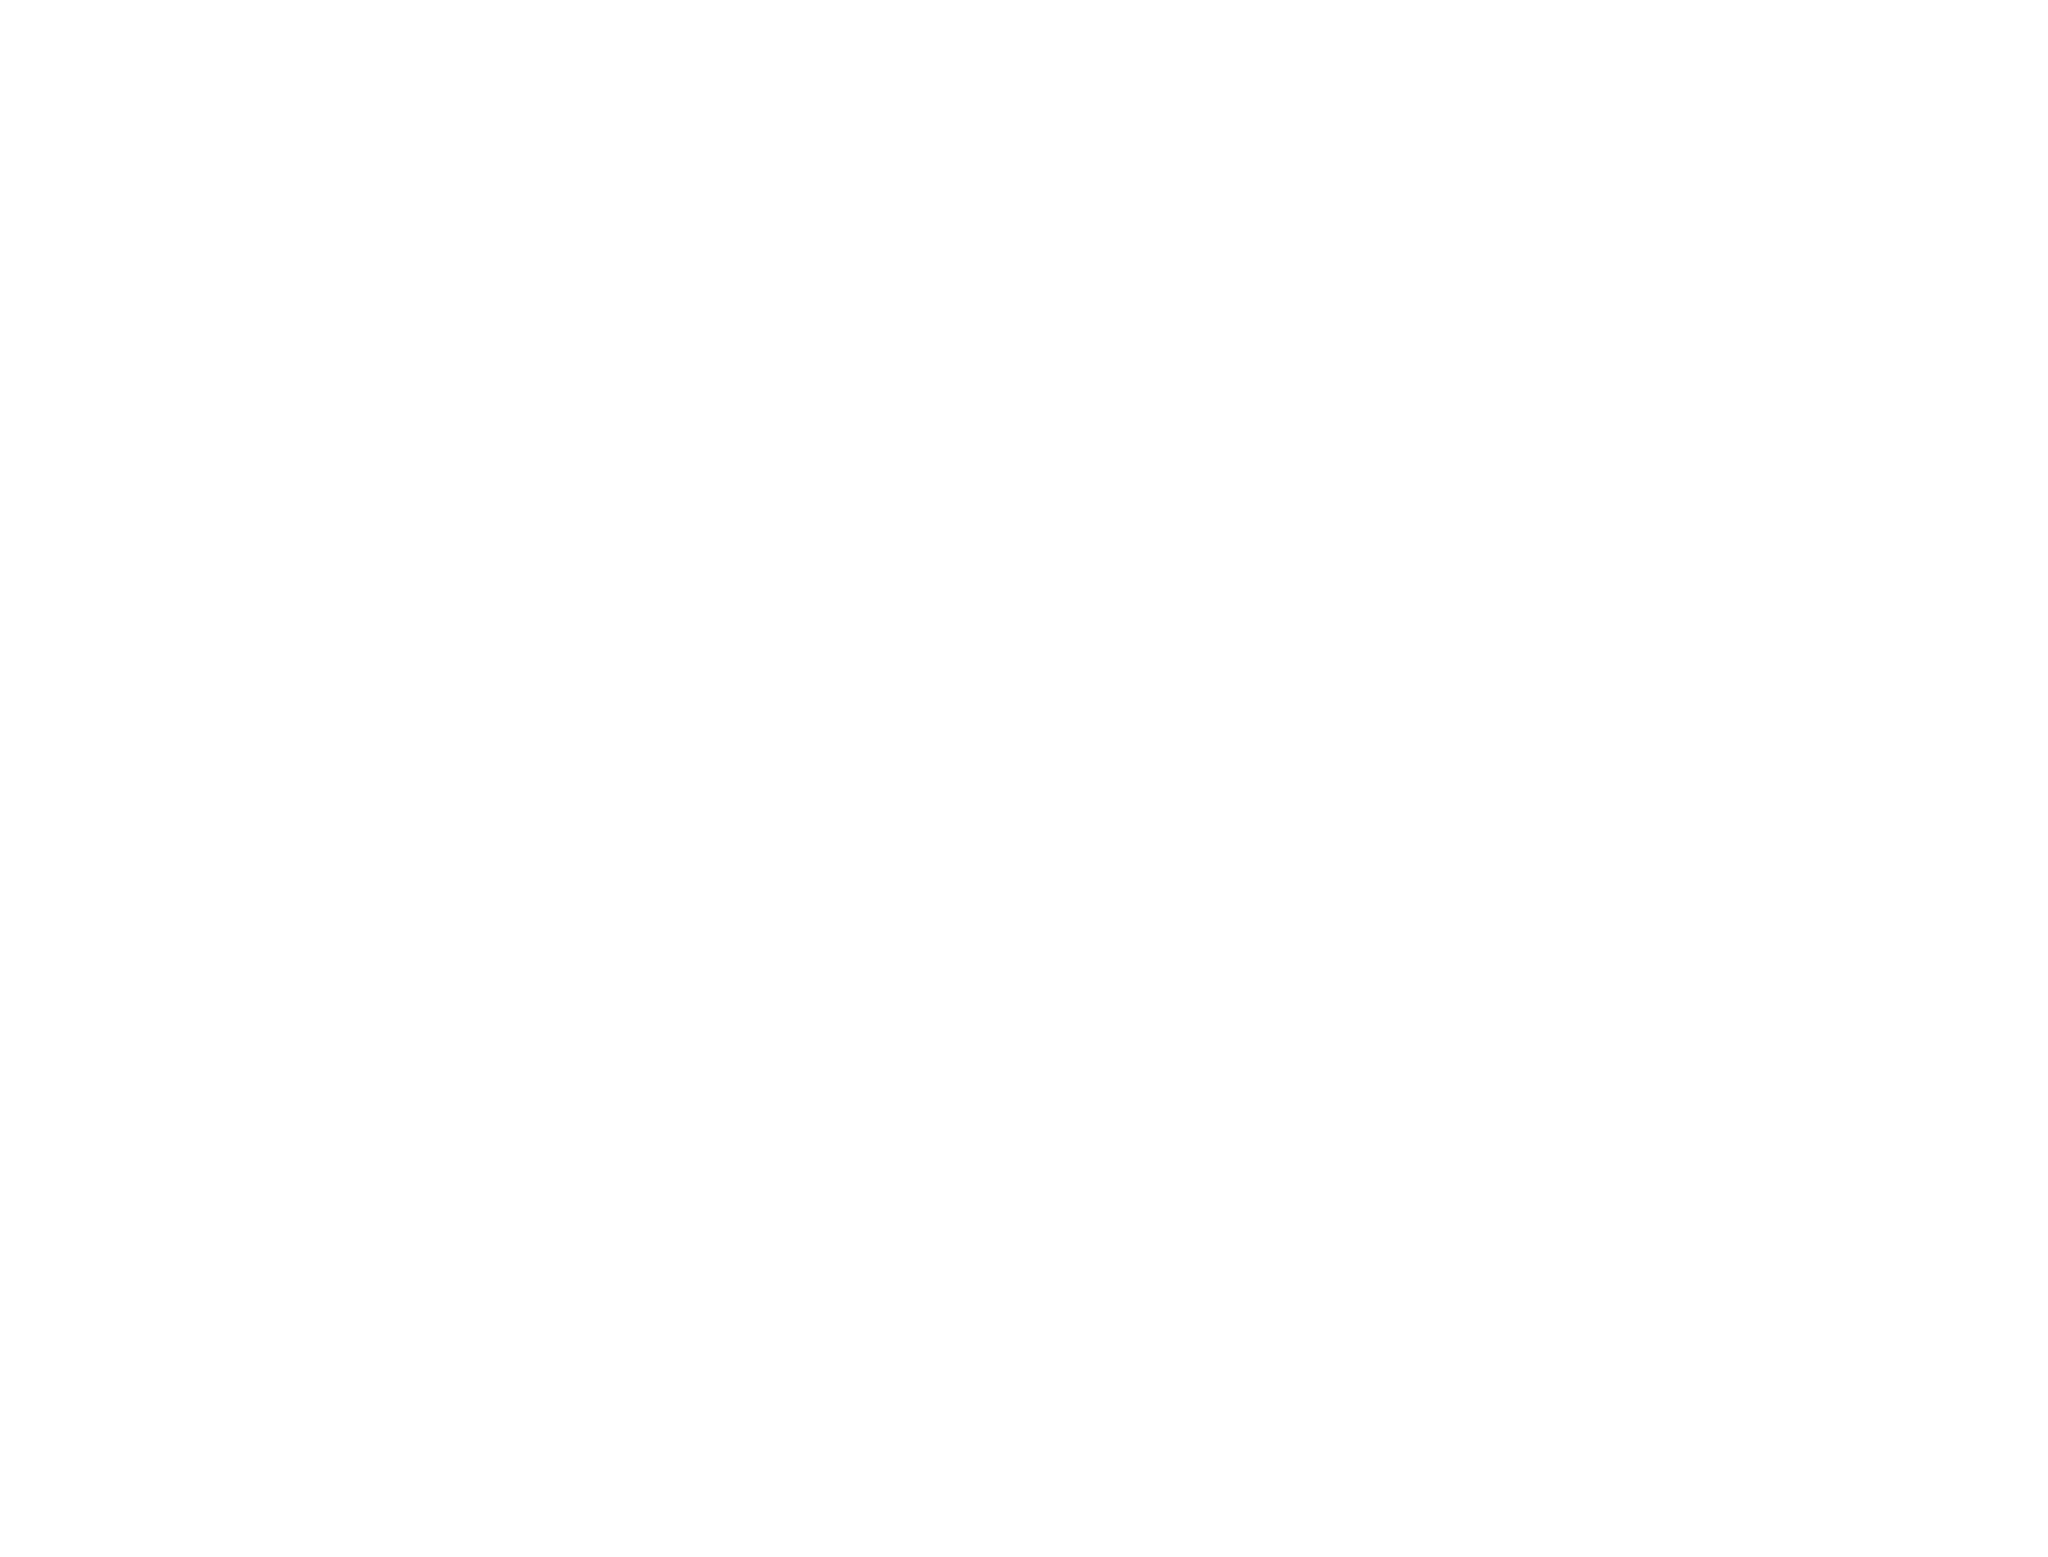

    63224       -12      0.510655   0.000191171
374.162      7984.31     -13      0.487432   0.000189817
374.16       261.196     -14      0.484883   0.000189622
 Variances and Principal Axes
                 2        5  
 3.7992E-11| -0.0001   1.0000  
 3.8787E-03|  1.0000   0.0001  
------------------------------

  Covariance Matrix
        1           2   
   3.879e-03   3.271e-07
   3.271e-07   6.558e-11
------------------------

Model TBabs<1>*zTBabs<2>*bremss<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    6.98000E-02  frozen
   2    2   zTBabs     nH         10^22    0.484883     +/-  6.22796E-02  
   3    2   zTBabs     Redshift            0.0          frozen
   4    3   bremss     kT         keV      10.2634      frozen
   5    3   bremss     norm                1.89622E-04  +/-  8.09837E-06  
________________________________________________________________________


Fit statistic  : C-Statist

In [8]:
# Fit the second spectrum by re-doing what we did in the first spectrum
spec21077 = SpectrumFit() 

# Use clear=True in loading new data to clear the previous spectrum loaded in PyXspec
# One can also just use xspec.AllData.clear() before fitting the second spectrum
spec21077.load_data(spec_files[1], clear=True)
spec21077.set_rebin(5, 3)
spec21077.ignore("**-0.5 8.0-**") # Chandra is well-calibrated in 0.5 - 8.0 keV

spec21077.set_model(
    "tbabs*ztbabs*bremss",
    zTBabs_nH=2.7,
    zTBabs_Redshift=0,
    # Here, we freeze the temperature for tutorial purposes
    bremss_kT=f"{df_temp['temperature'].iloc[1]} -1",
    bremss_norm=0
)

spec21077.fit()
spec21077.set_plot("ldata", device="/svg")
spec21077.get_params("1.0 2 5")
df_flux = spec21077.get_fluxes()
spec21077.get_time()
spec21077.get_counts()
spec21077.get_lumin(fluxes=df_flux['unabsorbed'], distance=dist) 
manager.load(spec21077)

## Plotting light curves
The light curves will be a normal matplotlib plot with labels is grouped by instruments

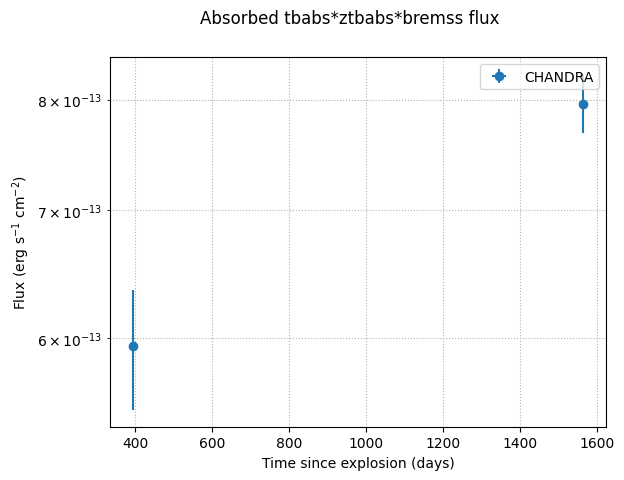

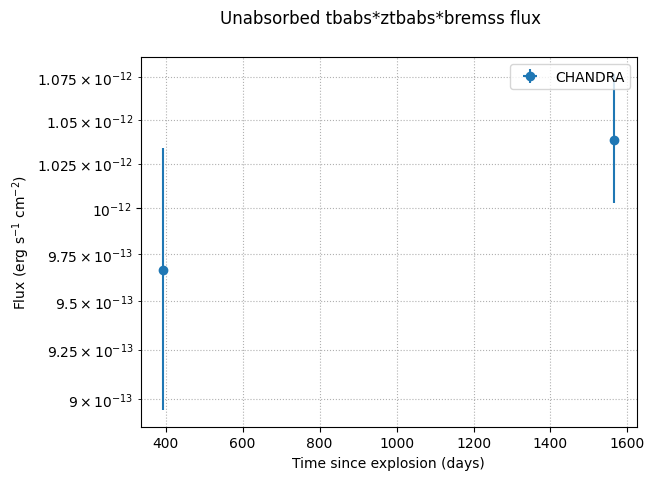

In [9]:
fig_fluxes = manager.plot_flux()

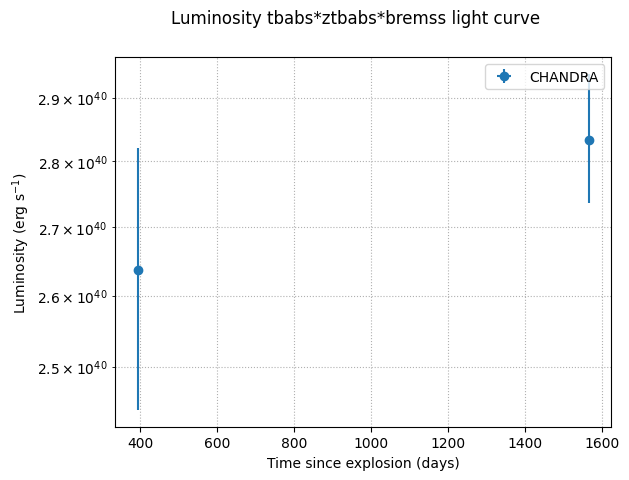

In [10]:
fig_lumin = manager.plot_lumin()

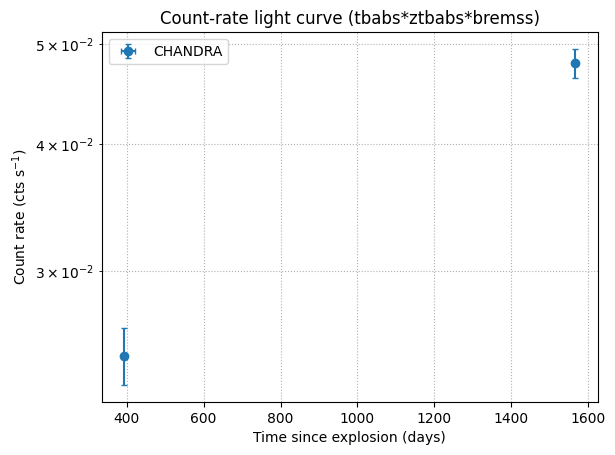

In [11]:
fig_counts = manager.plot_counts()

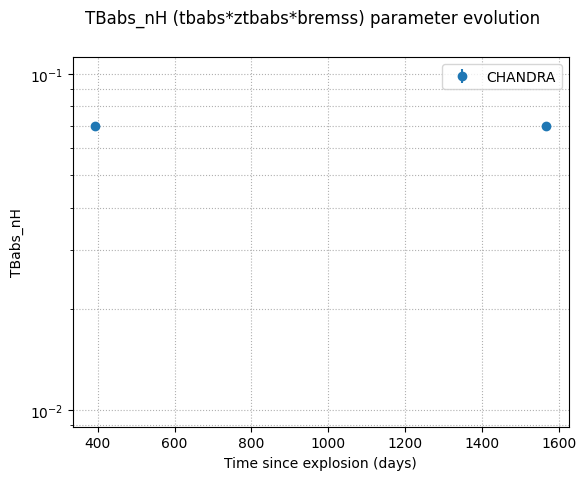

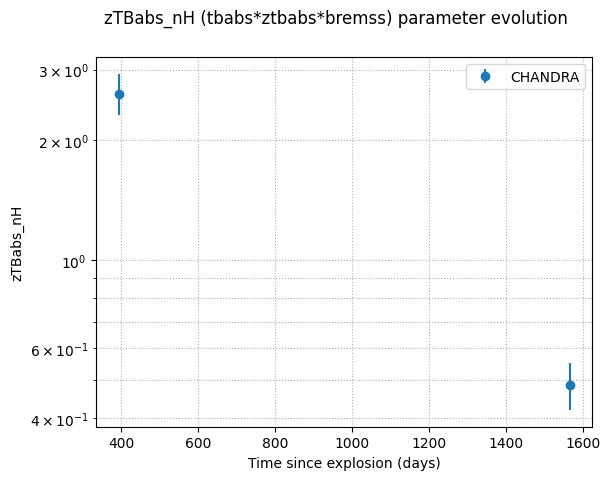

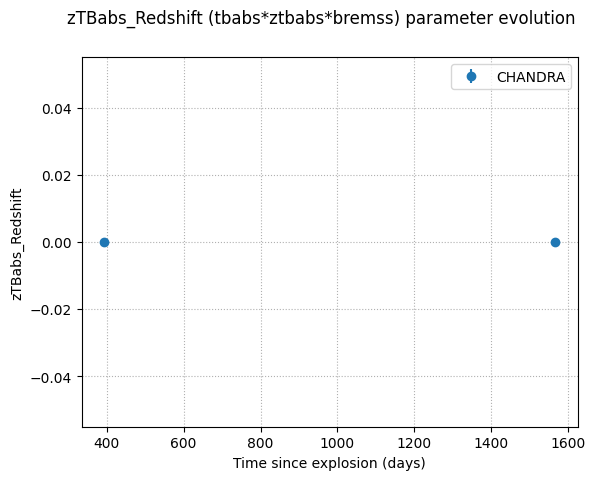

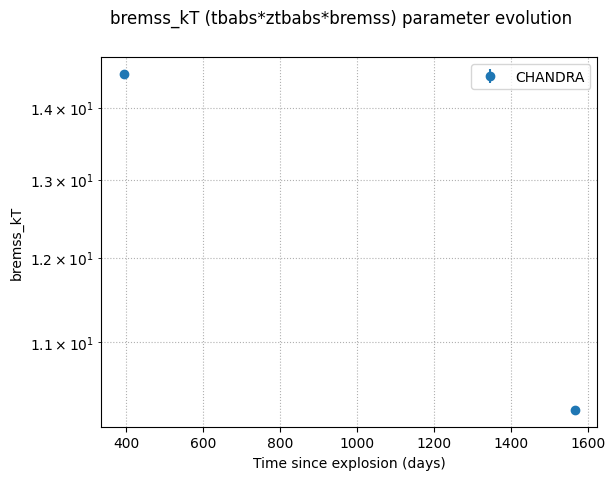

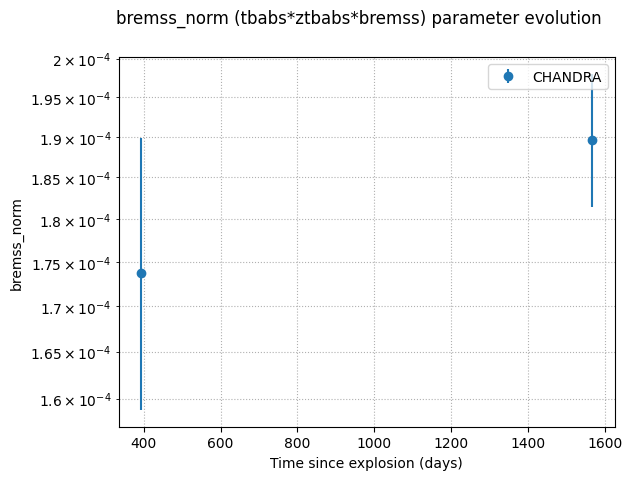

In [12]:
fig_params = manager.plot_params()

## CSM Analysis

With this analysis class, we can fit luminosity, temperature, and CSM density. From there, we can also estimate the mass-loss rate of the supernova progenitor.

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:12<00:00, 798.62it/s]


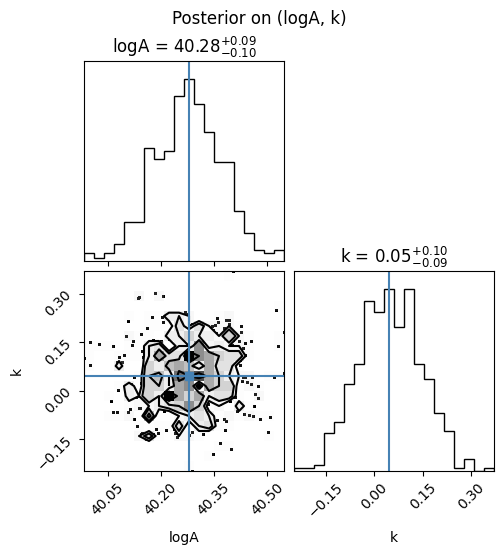

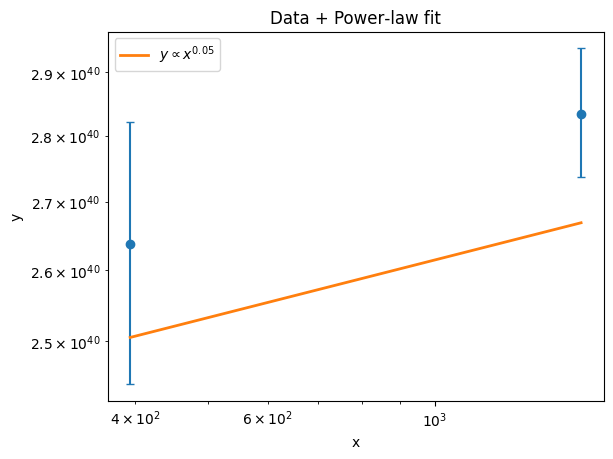

/Users/ferdinand/Research/WynnXraySN/XSNAP/src/xsnap/_fitting.py:312: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_red = chi2 / dof


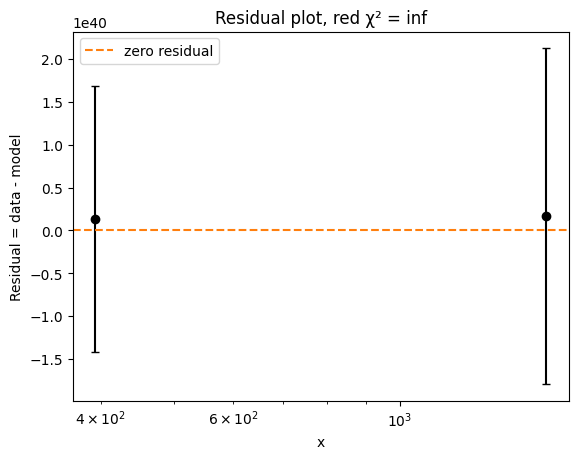

,model,norm,lo_norm_err,hi_norm_err,exp,lo_exp_err,hi_exp_err,ndata
0,tbabs*ztbabs*bremss,1.904780e+40,4.960042e+39,4.312637e+39,0.045843,0.093367,0.099176,2


In [13]:
analyzer = CSMAnalysis(manager)
df_fit = analyzer.fit_lumin()
df_fit

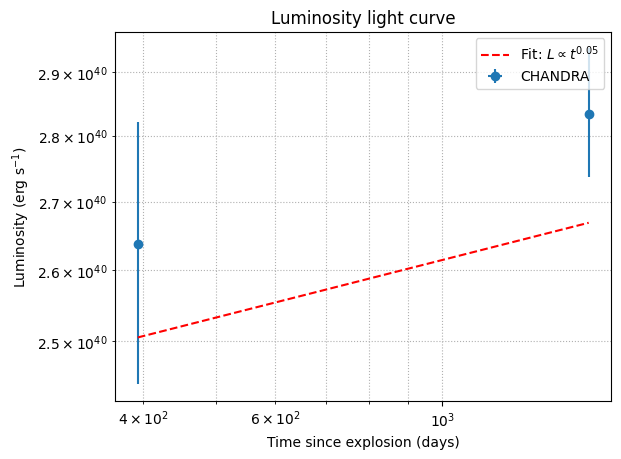

In [14]:
fig_lumin = analyzer.plot_lumin()

100%|██████████| 5000/5000 [02:45<00:00, 30.25it/s]


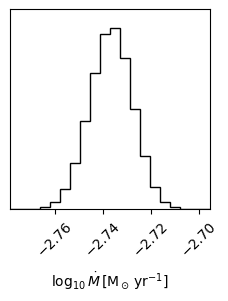

/Users/ferdinand/Research/WynnXraySN/XSNAP/src/xsnap/_fitting.py:312: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_red = chi2 / dof


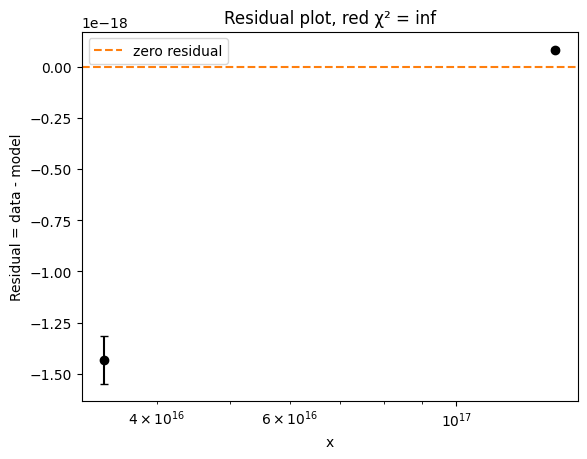

,time_since_explosion,rho,lo_rho_err,hi_rho_err
0,393.706775,2.542176e-18,1.088969e-19,1.181796e-19
1,1565.644759,3.349231e-19,7.167439e-21,7.429471e-21


In [16]:
df_densities = analyzer.calc_density(distance=dist, nwalkers=200, nsteps=5000, nburn=1000)
df_densities

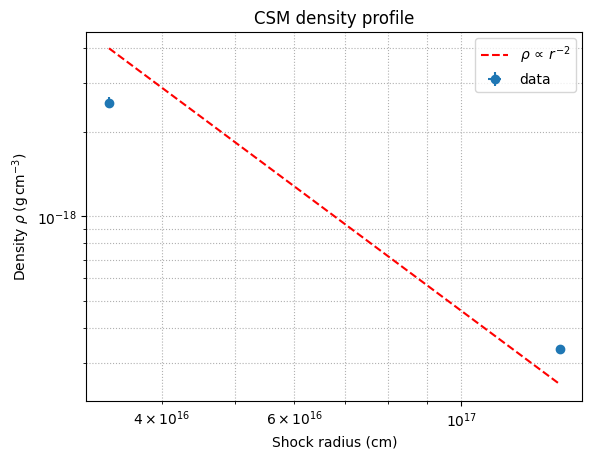

In [17]:
fig_density = analyzer.plot_density()

In [18]:
df_mass_loss = analyzer.get_mdot()
df_mass_loss # in Msolar/yr

,m_dot,lo_m_dot_err,hi_m_dot_err
0,0.001835,0.000038,0.000037
